### 核心组件
- 层：把输入tensor转换成输出tensor
- 模型：层组成的网络
- 损失函数：参数学习的目标函数
- 优化器：使损失函数最小

### pytorch构建神经网络
构建网络层layer可以基于Module或者functional。nn中的大多数layer都在functional中有对应的函数。functional和Module主要区别是后者继承了Module类，会自动提取可学习的参数，functional是纯函数。所以选择的时候，如果layer是conv，fc或者dropout这些含有可学习参数的，我们就选用Module，激活函数、pooling layer这种没有学习参数的就选用functional

### 使用pytorch进行MNIST手写数字分类
1. 利用pytorch内置mnist下载数据
2. 利用torchvision对数据进行预处理，使用torch.utils建立一个数据迭代器
3. 使用nn工具箱建立神经网络模型
4. 实例化模型，定义loss function以及optimizer
5. 训练模型
6. 可视化结果

In [1]:
import torch
import numpy as np
# 内置的mnist数据集
from torchvision.datasets import mnist
# 预处理模块
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
# nn以及优化器
from torch import nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
# 定义超参数
train_batch_size = 64
test_batch_size = 128
learning_rate = 0.01
num_epochs = 20
lr = 0.01
momentum = 0.5

In [5]:
# 定义预处理操作的函数
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5],[0.5])])

- transform.Compose可以把一些转换函数组合在一起
- Normalize([0.5],[0.5])对tensor进行归一化，分别表示均值和方差，mnist数据集中图像是灰色的所以只有一个通道，如果是多个通道，需要有多个数字，比如`Normalize([m1,m2,m3],[n1,n2,n3])`

In [7]:
# 下载数据并预处理
train_data = mnist.MNIST('./data',train=True,transform=transform,download=True)
test_data = mnist.MNIST('./data',train=False,transform=transform)
# dataloader是一个可迭代对象，可以像使用迭代器一样使用
train_loader = DataLoader(train_data,batch_size=train_batch_size,shuffle=True)
test_loader = DataLoader(test_data,batch_size=test_batch_size,shuffle=False)

Using downloaded and verified file: ./data/MNIST/raw/train-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


113.5%

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


100.4%

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


180.4%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


- download控制是否需要下载，如果./data下面有数据集就不需要了
- 使用Dataloader得到生成器可以节省内存

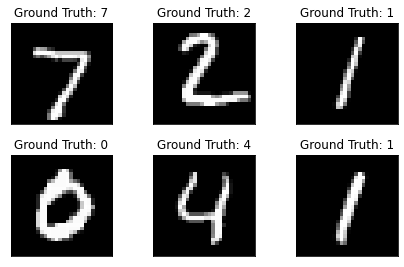

In [17]:
# 可视化数据
import matplotlib.pyplot as plt
%matplotlib inline

examples = enumerate(test_loader)
batch_idx,(example_data,example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray',interpolation='none')
    plt.title(f'Ground Truth: {example_targets[i]}')
    plt.xticks([])
    plt.yticks([])

In [18]:
batch_idx

0

In [20]:
example_data.shape
# 可以看到这里取出来的是128个图片，然后1个通道，大小是28x28

torch.Size([128, 1, 28, 28])

In [25]:
example_targets
# 一个一维tensor

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0,
        2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4,
        1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2,
        5, 4, 7, 6, 7, 9, 0, 5])

### 使用Module构建网络

In [26]:
class Net(nn.Module):
    def __init__(self,in_dim,n_hidden_1,n_hidden_2,out_dim):
        super(Net,self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_dim,n_hidden_1),nn.BatchNorm1d(n_hidden_1))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1,n_hidden_2),nn.BatchNorm1d(n_hidden_2))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2,out_dim))
        
    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        
        return x

In [27]:
device = torch.device('cuda:0' if torch.cuda.is_available() else'cpu')

In [28]:
device

device(type='cpu')

In [29]:
# 输入就是展平的图像，剩下的依次是神经元个数
model = Net(28*28,300,100,10)
model.to(device)

Net(
  (layer1): Sequential(
    (0): Linear(in_features=784, out_features=300, bias=True)
    (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer3): Sequential(
    (0): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [30]:
# 损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

#### 训练模型

In [34]:
for a,b in train_loader:
    print(a.shape)
    print(b.shape)
    break
# 这里可以看出来Dataloader里面是怎么存储的

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [35]:
losses = []
acces = []
eval_losses = []
eval_acces = []

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    
    model.train()
    
    # 动态修改学习率，加不加这个都可以
    if epoch % 5 == 0:
        optimizer.param_groups[0]['lr'] *= 0.1
    
    for img, label in train_loader:
        img = img.to(device)
        label = label.to(device)
        img = img.view(img.size(0),-1) # 展平成64x(28*28*1)
        # 前向传播
        out = model(img)
        loss = criterion(out,label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
        # 计算分类准确率
        _,pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.size(0)
        train_acc += acc
    
    losses.append(train_loss / len(train_loader))
    acces.append(train_acc / len(train_loader))
    
    eval_loss = 0
    eval_acc = 0
    # 模型改为预测模式
    model.eval()
    for img,label in test_loader:
        img = img.to(device)
        label = label.to(device)
        img = img.view(img.size(0),-1) # 展平成64x(28*28*1)
        # 前向传播
        out = model(img)
        loss = criterion(out,label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        eval_loss += loss.item()
        # 计算分类准确率
        _,pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.size(0)
        eval_acc += acc
        
    eval_losses.append(eval_loss / len(test_loader))
    eval_acces.append(eval_acc / len(test_loader))
    
    print(f'epoch: {epoch}, Train loss: {train_loss / len(train_loader):.4f}, Train acc: {train_acc / len(train_loader):.4f}, Test Loss: {eval_loss / len(test_loader):.4f}, Test acc: {eval_acc / len(test_loader):.4f}')
    

epoch: 0, Train loss: 1.0250, Train acc: 0.7784, Test Loss: 0.4073, Test acc: 0.9001
epoch: 1, Train loss: 0.4688, Train acc: 0.9028, Test Loss: 0.2815, Test acc: 0.9280
epoch: 2, Train loss: 0.3382, Train acc: 0.9222, Test Loss: 0.2270, Test acc: 0.9409
epoch: 3, Train loss: 0.2758, Train acc: 0.9340, Test Loss: 0.1936, Test acc: 0.9488
epoch: 4, Train loss: 0.2348, Train acc: 0.9426, Test Loss: 0.1690, Test acc: 0.9548
epoch: 5, Train loss: 0.2151, Train acc: 0.9460, Test Loss: 0.1750, Test acc: 0.9579


KeyboardInterrupt: 

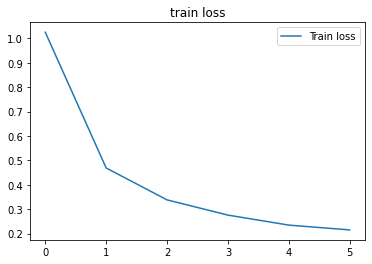

In [36]:
plt.title('train loss')
plt.plot(np.arange(len(losses)),losses)
plt.legend(['Train loss'],loc='upper right')

In [37]:
test_loader